# Predicting Churn for SyriaTel Customers

Authors: John Sheehan & Tom Chapman

# Overview

# Business Problem

We (XXXX COMPANY) are customer outreach specialists retained by SyriaTel to help reduce customer loss. As one of only two mobile service providers in Syria, SyriaTel is in constant competition with their only competition (MTN Syria) for wireless customers. Because they have a binary choice of provider, it is relatively easy for customers to compare their options for wireless service and find the best price and service. It is therefore critical for SyriaTel to understand if price per minute is the most important driver of customer behavior or if there are other services that play a large role. 

They would like to begin an outreach program to customers that are at a high risk of churning to avoid unnecessary runoff. The first step in that process is to use the dataset to identify predictors of churn in their customer base so that they can identify which customers are at a high risk of leaving. We have been charged with building a model that will effectively predict customer churn, and identifying which features of their dataset are most important within that prediction.

We will apply several classifiers to the dataset to determine which might be most effective, and then tune the hyperparameters of the most effective models to arrive at our final recommendation.


# Data Understanding

For this analysis, we used a dataset of 3,333 SyriaTel customers. The dataset included customer profile information typical to the wireless space--phone number, state, area code, etc.--along with usage statistics and an indicator of whether or not the customer ultimately left SyriaTel (churned). 

In the following section, we review the datatypes in our customer base, perform some exploratory visualizations, and look for extraneous data within the dataset.

In [2]:
# Package Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Pipeline Imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import warnings
from pprint import pprint

In [3]:
# Read in customer data & review features & datatypes
df = pd.read_csv('./data/original_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
# Drop phone number from the dataset.
df.drop('phone number', axis=1, inplace=True)

### EDA Summary
State, phone number, intl plan, voice mail plan are objects -- need to encode

Account Length - maybe days, how long customer has been with company

6 - 18 Usage Stats = number of calls number of minutes and charge for different time categories.

19 - # of customer service calls

Possible Churn Indicators:

- By State?
- High Customer Service Contact = high churn?
- Low Calls/Low minutes = higher churn?
- Can we identify a customer profile that is likely to churn for targeted marketing/incentives?
- Drop Phone number -- basically a unique identifer for every customer, not likely to help in predictions

- Location
    - State/Area Code
    
- Duration
    - Account Length
    
- Plan Types
    - Intl / Voicemail
    
- Usage Stats
    - minutes
    - num calls
    - charges
    - customer service calls

Drop Phone number

Encoding Process:
    - voicemail plan = Ordinalencoder 1/0
    - international plan = Ordinalencoder 1/0
    - state - one-hot encoding

Scale Numerical Features





#### Overall Churn Rate

To provide a point of comparison, we idenfied the percentage of customers within the data that churned.

In [5]:
# Calculate Overall Churn Rate
print(df[df['churn'] == True].shape)
print(f" Percentage of dataset representing churned customers: ", round(483/3333, 2), ".")

(483, 20)
 Percentage of dataset representing churned customers:  0.14 .


#### Churn Rate by State
We plotted a bar graph of churned(orange) and non-churned(blue) customers by state to assess visually if there is any obvious relationship. It does not appear that a customer's state has a meaningful impact on whether or not they will churn.

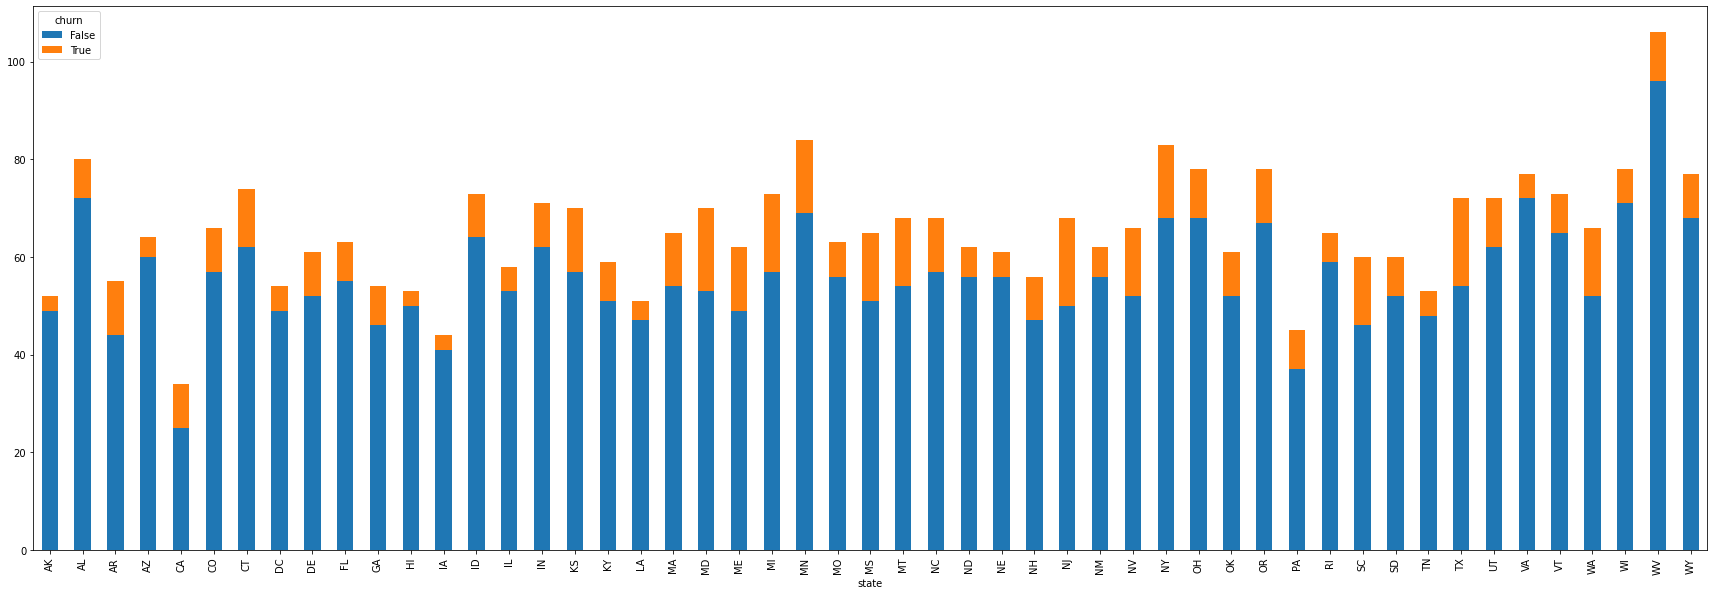

In [6]:
df.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)); 

#### Churn Rate by Area Code

We plotted a bar graph of churned(orange) and non-churned(blue) customers by area code to assess visually if there is any obvious relationship. While it appears there might be a small variance by area code, we quickly identified that the presence of only 3 area codes across a dataset that includes 51 states (including DC) is suspicious. While it is possible that customers from all 51 states are assigned phone numbers from only 3 area codes, more information will be needed from SyriaTel to confirm the data's accuracy.

In [7]:
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

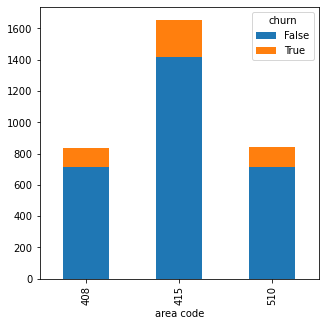

In [8]:
df.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

#### Churn Rate Among Users with Voicemail Plan

We plotted a bar graph of churned(orange) and non-churned(blue) customers by the presence of a voicemail to assess visually if there is any obvious relationship. It does not appear that a customer's use of voicemail predicts that they will churn. In fact, only 8.7% of voice mail users ended up churning compared to ~15% of the overall dataset. More analysis will be needed to determine how meaningful this feature is. 

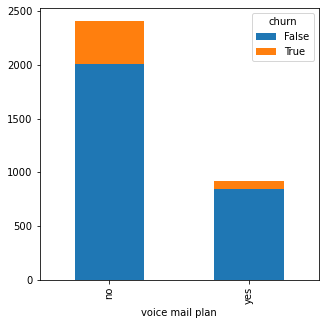

In [9]:
df.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

Interestingly, the number proportion of voicemail customers that churned is much lower than the overall churn rate. That could suggest that use of voicemail makes the customer relationship stickier, and that further marketing of the product could improve retention. Further analysis is needed to confirm. 

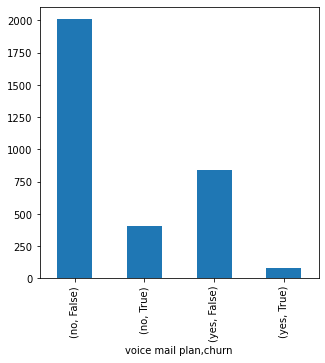

In [10]:
df.groupby(["voice mail plan", "churn"]).size().plot(kind='bar', stacked=True, figsize=(5,5));

In [11]:
print(df[df['voice mail plan'] == 'yes'].shape)

(922, 20)


In [12]:
df_vm = df[df['voice mail plan'] == 'yes']
df_vm['churn'].value_counts()

False    842
True      80
Name: churn, dtype: int64

In [13]:
print(80/(80+842))

0.08676789587852494


#### Churn Among Users with International Plan

Similar to voicemail users, we plotted a bar graph of churned and non-churned customers customers by the presence of an international plan to assess visually if there is any obvious relationship. In constrast to our other features, international plan usage seems to be extremely important in predicting customer churn. About 42% of international plan users end up moving to another provider--much higher than the 15% baseline. We therefore expect our modelling efforts to identify international plan usage as an important predictor of churn.


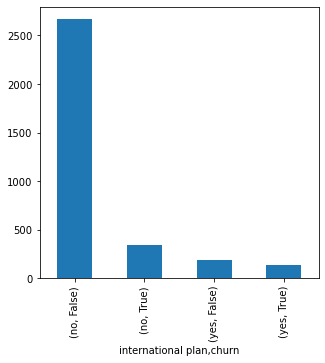

In [14]:
df.groupby(["international plan", "churn"]).size().plot(kind='bar', stacked=True, figsize=(5,5));

In [15]:
df_churn = df[df['international plan'] == 'yes']
df_churn['churn'].value_counts()

False    186
True     137
Name: churn, dtype: int64

In [16]:
print(137/(137+186))

0.4241486068111455


#### Train Test Split

In [17]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 2360 to 3174
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2233 non-null   object 
 1   account length          2233 non-null   int64  
 2   area code               2233 non-null   int64  
 3   international plan      2233 non-null   object 
 4   voice mail plan         2233 non-null   object 
 5   number vmail messages   2233 non-null   int64  
 6   total day minutes       2233 non-null   float64
 7   total day calls         2233 non-null   int64  
 8   total day charge        2233 non-null   float64
 9   total eve minutes       2233 non-null   float64
 10  total eve calls         2233 non-null   int64  
 11  total eve charge        2233 non-null   float64
 12  total night minutes     2233 non-null   float64
 13  total night calls       2233 non-null   int64  
 14  total night charge      2233 non-null

In [19]:
X_train['voice mail plan'].value_counts()

no     1621
yes     612
Name: voice mail plan, dtype: int64

In [20]:
# Assign each column to a list based on its datatype--either numerical or categorical
#num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
#cat_cols = [0, 3, 4]

## Pipeline Construction

To facilitate more efficient modelling, we will construct a column transformer that performs all necessary data transformation & scaling and then runs the appropriate model. Our transformer contains three subpipes, each of which includes an encoder or scaler as appropriate based on the data type. Specifically, we will ordinal encode the yes/no values of international plan and voicemail plan, one-hot encode a customer's state, and apply a standard scaler to all numerical data.

**A note regarding imbalanced data:**
Within our dataset, only 483 of the 3,333 customers actually churned. Therefore, we have an imbalanced set that must be addressed in order for our modelling to function well. To address this imbalance, we will use SMOTE to oversample our minority class of churned customers to more closely resemble a full dataset. According to [Statista.com](https://www.statista.com/statistics/816735/customer-churn-rate-by-industry-us/), the average churn rate among wireless providers is about 22%. We therefore do not want a completely balanced dataset, and will use a smote strategy that retains a 25% imbalance in the data.

# REVIST THIS AFTER WE GRIDSEARCH FOR SMOTE

In [21]:
# Define functions to identify and select columns based on the datatype stored in that column.
def get_numeric(df):
    return df.select_dtypes(include=['float64', 'int64'])

def get_categorical(df):
    return df.select_dtypes(include=['bool', 'object'])

# Create transformer objects using our get functions
GetNumeric = FunctionTransformer(get_numeric)
GetCategories = FunctionTransformer(get_categorical)

In [22]:
# Subpipelines to select and scale our numeric data / select and one-hot encode our categorical data.
subpipe_num = Pipeline(steps=[('num', GetNumeric),
                                ('ss', StandardScaler())])
 
subpipe_ohe = Pipeline(steps=[('cat', GetCategories), 
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

subpipe_ord = Pipeline(steps=[('ord', OrdinalEncoder())])

In [23]:
# Create lists of numeric and categorical columns.
num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
num_cols = list(df.columns[num_cols])
cat_cols = ['state']
ord_cols = [3, 4]
ord_cols = list(df.columns[ord_cols])

# Create ColumnTransformer object that contains our subpipes for column transformation
CT = ColumnTransformer(transformers=[
                                    ('subpipe_num', subpipe_num, num_cols),
                                    ('subpipe_ohe', subpipe_ohe, cat_cols),
                                    ('subpipe_ord', subpipe_ord, ord_cols)]
                      )

In [24]:
# Avg churn rate is 22% for all providers, we elect a smote strategy of 25%.

sm = SMOTE(sampling_strategy=0.75, random_state=42)

## Functions

We created three custom functions to be used when evaluated our models:

- **cross_val** is a cross validation function that prints the mean, median and standard deviation of the f1 score of each model. 

- **get_column_names_from_ColumnTransformer** is a custom function written by a user in the sklearn support forums to allow retrieval of column names within a CT within a pipeline. This feature was later added to sklearn, but was not present in version 0.23, which was utilized for this analysis.

- **get_feature_importance** retrieves the feature importance and feature name from each model pipeline and plots a bar graph that displays the ten most important features as identified by the model.



In [25]:
# This function will allow for quick cross-validation of the f1 score for each of our models.
def cross_val(model, X, y, kfolds=10):
    """ Perform cross-validated scoring and store/print results """
    f1_results = cross_val_score(model, X, y, cv=kfolds, scoring='f1')
    f1_mean = np.mean(f1_results)
    f1_median = np.median(f1_results)
    f1_std = np.std(f1_results)
    print(f"Mean f1 score: ", {f1_mean}, ".")
    print(f"Median f1 score: ", {f1_median}, ".")
    print(f"Standard Deviation in f1 score: ", {f1_std}, ".")

In [26]:
# This function will allow us to extract the column names of the data that is transformed in our pipelines.

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

# Credit to Joey Gao @ https://github.com/scikit-learn/scikit-learn/issues/12525 for the shell of this function.

In [27]:
def get_feature_importance(model, mod_type, X, y):
    """ 
    Get feature importances, use get_column_names_from_ColumnTransformer grab column names and plot a horizontal bar
    graph of the 10 most important features when run on a pipeline that contains a model.
    """
    # Grab feature importances & column names
    feature_importance = model.named_steps[mod_type].feature_importances_
    feature_names = get_column_names_from_ColumnTransformer(CT)
    feature_names = [name.title() for name in feature_names]
    
    # Create dataframe of feature importances & feature names to facilitate easier plotting
    feat_importances = pd.DataFrame(model.named_steps[mod_type].feature_importances_, index=feature_names)
    feat_importances = feat_importances[0].nlargest(10)
     
    # Plot basic horizontal bar graph of 10 most important features.                        
    fig, ax = plt.subplots()
    ax = feat_importances.plot(kind='barh' , figsize=(10,10))
    ax.set_xlabel('Attribute Importance')
    ax.set_ylabel('Customer Attributes')
    ax.set_title('Attributes Most Predictive of Churn')

# Modelling

For our analysis we elected to use the f1 score to evaluate our models. The f1 score provides a balance between the importance of false positives and false negatives, and does not reward accuracy at the cost of recall/precission. Given that SyriaTel intends to perform customer outreach to customer groups at risk of churn, we assume there is a significant cost associated with making the outreach group too broad. Providing a discount or promotional rate to customers that had no intention of shopping around might improve loyalty, but it will certainly hurt the company's bottom line. Similarly, we need to avoid false negative tests where we assume a customer is not at risk of churn when they are actually thinking about shoppiing around. A lost customer is likely to be very damaging to the company's revenue. 

## Dummy Classifier

We began with a Dummy Classifier model to serve as a baseline. This model simply guesses the most common target variable in the dataset for every record it is presented. Because we have so many true falses in our dataset, the classifer guesses false for every record. This leads to an f1 score of 0, since the numerater of f1 score includes multiplication by zero.

In [28]:
# Definte a pipeline to transform and smote our data using the subpipes defined above, and apply a Dummy Classifier
dummy_model_pipe = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dc', DummyClassifier(strategy='most_frequent', random_state=42))
                                       ]
                                )

In [29]:
dummy_model_pipe.fit(X_train, y_train)
cross_val(dummy_model_pipe, X_train, y_train)

Mean f1 score:  {0.0} .
Median f1 score:  {0.0} .
Standard Deviation in f1 score:  {0.0} .


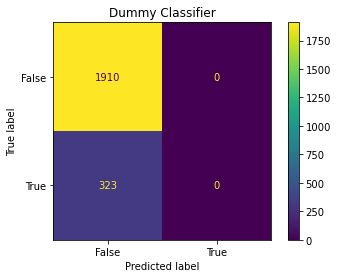

In [30]:
plot_confusion_matrix(dummy_model_pipe, X_train, y_train)
title = 'Dummy Classifier'
plt.title(title);

## Logistic Regression - First Simple Model

We elected to use linear regression as our first simple model because it's relatively easy to implement and very efficient to train. As expected given that much of our data is non-linear, the model struggled badly. Due to the poor performance, we did not iterate on this model.

In [31]:
# Define logistic regression pipeline using ColumnTransformer and Smote from above
lr_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('lr', LogisticRegression(random_state=42))
                                       ]
                                )



In [32]:
lr_pipeline.fit(X_train, y_train)

cross_val(lr_pipeline, X_train, y_train)

Mean f1 score:  {0.47585886006760036} .
Median f1 score:  {0.4835748792270531} .
Standard Deviation in f1 score:  {0.055112667756457956} .


In [33]:
lr_y_hat = lr_pipeline.predict(X_test)
print(classification_report(y_test, lr_y_hat))

              precision    recall  f1-score   support

       False       0.93      0.82      0.87       940
        True       0.38      0.65      0.48       160

    accuracy                           0.80      1100
   macro avg       0.66      0.74      0.68      1100
weighted avg       0.85      0.80      0.82      1100



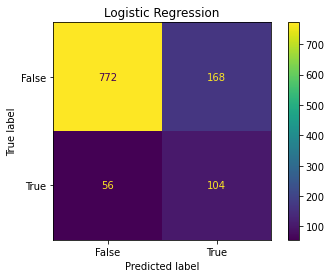

In [34]:
plot_confusion_matrix(lr_pipeline, X_test, y_test)
title = 'Logistic Regression'
plt.title(title);

## K-Nearest Neighbors

For our second model, we attempted a KNN classifier. The model's ease of implementation and lack of training period made it an appealing early step. Similar to our logistic regression model, the KNN model struggled badly with the dataset and performed quite poorly in terms of f1 score. We did not iterate on this model due to the poor performance.

In [35]:
knn_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('knn', KNeighborsClassifier())
                                       ]
                                )

In [36]:
knn_pipeline.fit(X_train, y_train)
cross_val(knn_pipeline, X_train, y_train)

Mean f1 score:  {0.44515018728655065} .
Median f1 score:  {0.4341013824884793} .
Standard Deviation in f1 score:  {0.03531257224889898} .


In [37]:
knn_y_hat = knn_pipeline.predict(X_train)
print(classification_report(y_train, knn_y_hat))

              precision    recall  f1-score   support

       False       1.00      0.86      0.92      1910
        True       0.54      0.98      0.70       323

    accuracy                           0.88      2233
   macro avg       0.77      0.92      0.81      2233
weighted avg       0.93      0.88      0.89      2233



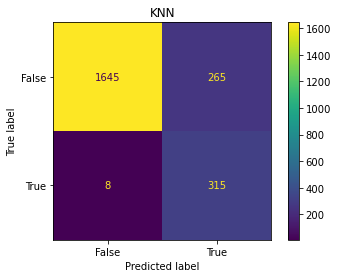

In [38]:
plot_confusion_matrix(knn_pipeline, X_train, y_train)
title = 'KNN'
plt.title(title);

# DecisionTree

For our third model, we decided to use a decision tree because, for a classification model, it is relatively simple to explain to stakeholders. It performed noticeably better on cross-validated f1 score, but struggled badly with overfitting. Given the superior performance of this tree-based model, we decided to use Random Forest and Gradient Boosted Classifiers as our next approach.

In [39]:
dt_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dt', DecisionTreeClassifier(random_state=42))
                                       ]
                                )

In [40]:
dt_pipeline.fit(X_train, y_train)
cross_val(dt_pipeline, X_train, y_train)

Mean f1 score:  {0.6813362815421017} .
Median f1 score:  {0.6824175824175824} .
Standard Deviation in f1 score:  {0.07924240983682433} .


In [41]:
dt_y_hat = dt_pipeline.predict(X_train)
print(classification_report(y_train, dt_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



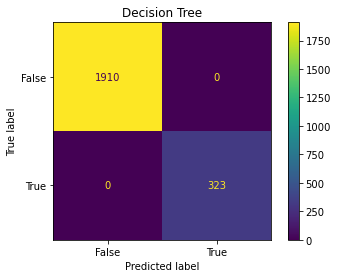

In [42]:
plot_confusion_matrix(dt_pipeline, X_train, y_train)
title = 'Decision Tree'
plt.title(title);

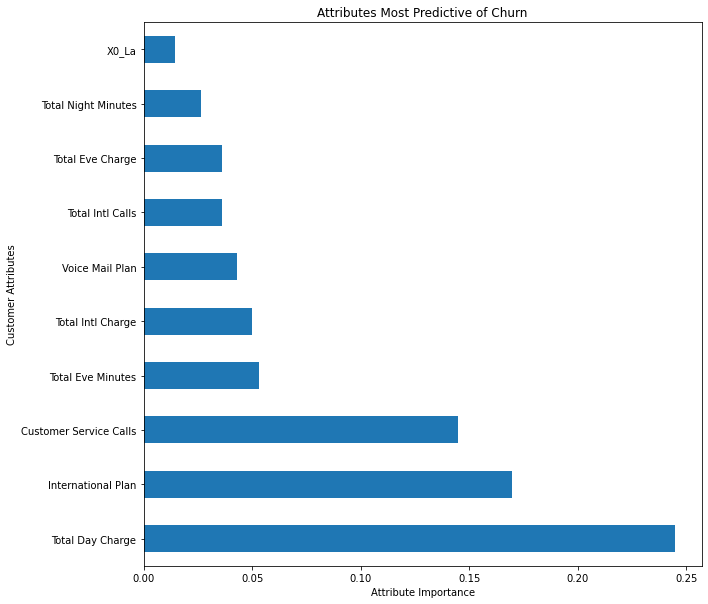

In [43]:
get_feature_importance(dt_pipeline, 'dt', X_train, y_train)

# Random Forest

Our Random Forest model ended up being the 2nd best model out of all of the models that we ran when comparing between our base classification models so we wanted to take this model and our best model, the gradient boosted classifier, and run grid searches on them to see which performed better between the two given better hyper parameters.

In [44]:
rf_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('rf', RandomForestClassifier(random_state=42))
                                       ]
                                )

In [45]:
rf_pipeline.fit(X_train, y_train)
cross_val(rf_pipeline, X_train, y_train)

Mean f1 score:  {0.7554505669905633} .
Median f1 score:  {0.7627118644067796} .
Standard Deviation in f1 score:  {0.057480336321058756} .


In [46]:
rf_y_hat = rf_pipeline.predict(X_train)
print(classification_report(y_train, rf_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



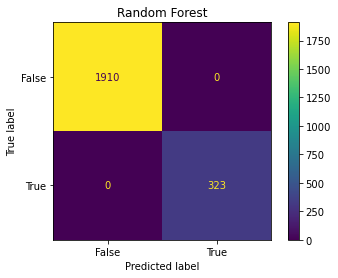

In [47]:
plot_confusion_matrix(rf_pipeline, X_train, y_train)
title = 'Random Forest'
plt.title(title);

We looked at the base feature importances for our random forest model

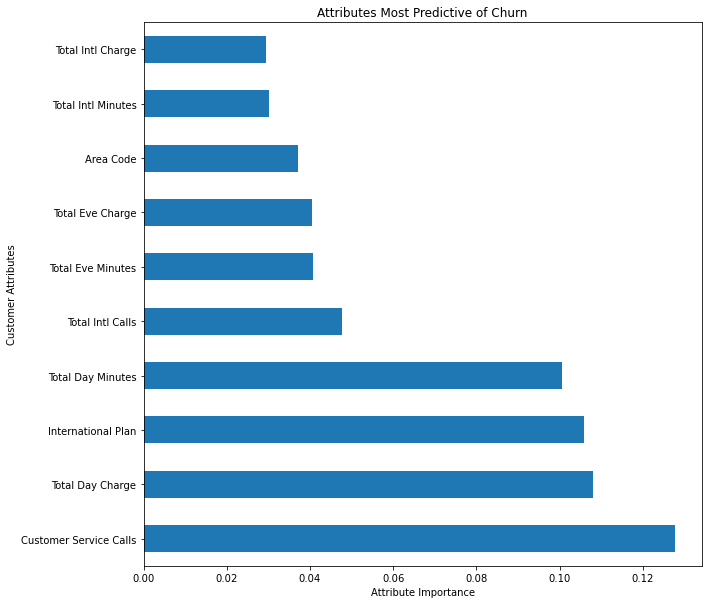

In [48]:
get_feature_importance(rf_pipeline, 'rf', X_train, y_train)

### Tuning Random Forest Classifier with Grid Search

Now that we have a base model we started running grid searches to try and find the best hyper parameters for our Random forest model.

In [49]:
# Print out original parameters of rf classifier in rf_pipeline
print('Current Parameters:\n')
pprint(rf_pipeline.named_steps['rf'].get_params())

Current Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [50]:
# Define new set of parameters to grid-search over
rf_params = {
            'rf__n_estimators': [10, 20, 30],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2, 4, 6],
            'rf__min_samples_split': [2, 5, 10],
            'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'rf__bootstrap': [True, False]
             }

# Instantiate grid search object using parameters defined above.
# rf_gs = GridSearchCV(rf_pipeline, param_grid=rf_params, n_jobs=-4, verbose=3, cv=10)

# Fit the grid search object on training data
# rf_gs.fit(X_train, y_train)

# Find the best parameters based off of our grid search
# rf_gs.best_params_

The first Random Forest grid search found the best parameters of:
- bootstrap= True
- criterion: 'entropy'
- max_depth=40
- min_samples_leaf=2
- min_samples_split=10
- n_estimators=30

### First RF turned model

Our first tuned model is better than our base model given the mean f1 score went from .755 to .771 but can be tuned even further.

In [51]:
rft_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('rft', RandomForestClassifier(bootstrap= True,
                                                                       criterion='entropy',
                                                                       max_depth=40,
                                                                       min_samples_leaf=2,
                                                                       min_samples_split=10,
                                                                       n_estimators=30,
                                                                       random_state=42))
                                       ]
                                )

In [52]:
rft_pipeline.fit(X_train, y_train)
cross_val(rft_pipeline, X_train, y_train)

Mean f1 score:  {0.7710092139844031} .
Median f1 score:  {0.7794075352315215} .
Standard Deviation in f1 score:  {0.051287243044799896} .


In [53]:
rft_y_hat = rft_pipeline.predict(X_train)
print(classification_report(y_train, rft_y_hat))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1910
        True       0.99      0.90      0.94       323

    accuracy                           0.98      2233
   macro avg       0.99      0.95      0.97      2233
weighted avg       0.98      0.98      0.98      2233



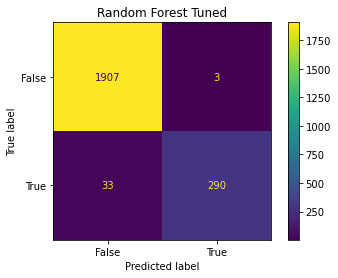

In [54]:
plot_confusion_matrix(rft_pipeline, X_train, y_train)
title = 'Random Forest Tuned'
plt.title(title);

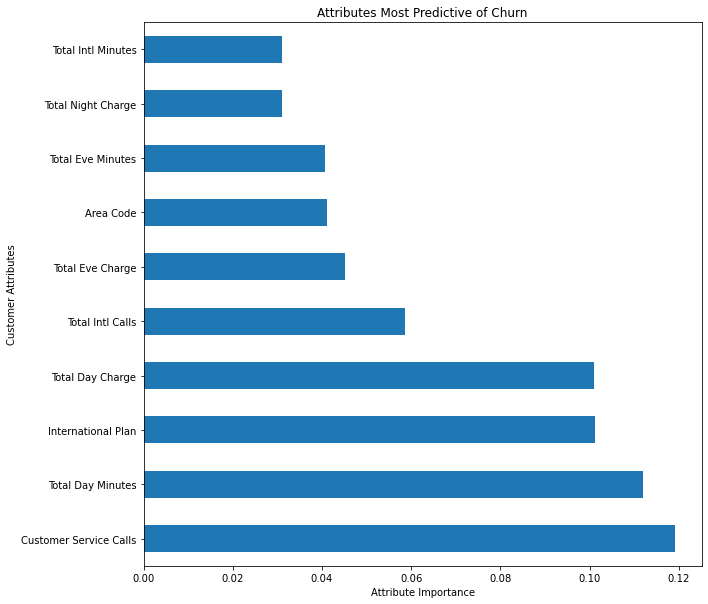

In [55]:
rft_importances = get_feature_importance(rft_pipeline, 'rft', X_train, y_train)

#### 2nd Random Forest Grid Search

Given our first grid search we wanted to further refine our hyper parameters to try and get a better model.

In [56]:
rf2_params = {
            'rf__criterion': ['gini', 'entropy'],
            'rf__n_estimators': [30, 50, 100, 200],
            'rf__min_samples_leaf': [1, 2, 3],
            'rf__min_samples_split': [5, 10, 15, 20],
            'rf__max_depth': [30, 35, 40, 45],
            'rf__bootstrap': [True, False]
             }
# Instantiate grid search object using parameters defined above.
# rf2_gs = GridSearchCV(rf_pipeline, param_grid=rf2_params, n_jobs=-4, verbose=3, cv=10)

# Fit the grid search object on training data
# rf2_gs.fit(X_train, y_train)

# Find the best parameters based off of our grid search
# rf2_gs.best_params_

The second Random Forest grid search found the best parameters of:

- bootstrap= False
- criterion: 'entropy'
- max_depth=30
- min_samples_leaf=2
- min_samples_split=5
- n_estimators=100

### Second RF Tuned model

Our second tuned model is better than our first tuned model but only by an increase of .006 mean f1 score, we are starting to get diminishing returns with each iteration of our grid search tuning so we are moving to our gradient boosted classifier model.

In [57]:
rft2_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('rft', RandomForestClassifier(bootstrap= False,
                                                                       criterion='entropy',
                                                                       max_depth=30,
                                                                       min_samples_leaf=2,
                                                                       min_samples_split=5,
                                                                       n_estimators=100,
                                                                       random_state=42))
                                       ]
                                )

In [58]:
rft2_pipeline.fit(X_train, y_train)
cross_val(rft2_pipeline, X_train, y_train)

Mean f1 score:  {0.7771199124342927} .
Median f1 score:  {0.7931034482758621} .
Standard Deviation in f1 score:  {0.05071377193364684} .


In [59]:
rft2_y_hat = rf_pipeline.predict(X_train)
print(classification_report(y_train, rft2_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



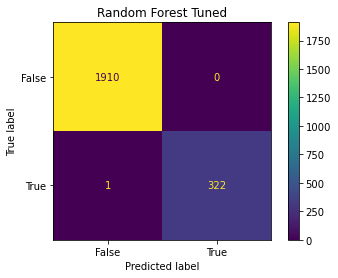

In [60]:
plot_confusion_matrix(rft2_pipeline, X_train, y_train)
title = 'Random Forest Tuned'
plt.title(title);

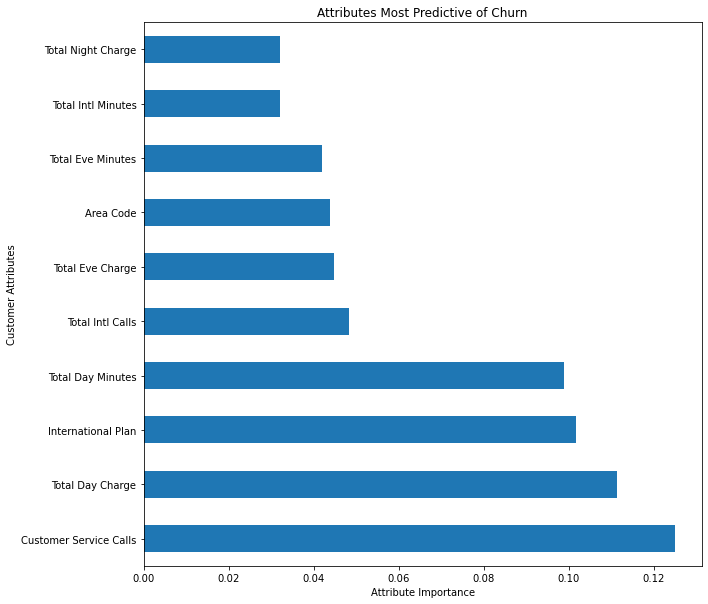

In [61]:
# Plot the 10 most important features
rft2_importances = get_feature_importance(rft2_pipeline, 'rft', X_train, y_train)

## Gradiant Boosted Classifier

We first ran our base gradient boosted classifier model we used to compare with our other base classification models and our tuned gradient boosted classifier models using grid search.

In [62]:
gbc_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('gbc', GradientBoostingClassifier())
                                       ]
                                )

In [63]:
gbc_pipeline.fit(X_train, y_train)
cross_val(gbc_pipeline, X_train, y_train)

Mean f1 score:  {0.7871808446886404} .
Median f1 score:  {0.7793103448275862} .
Standard Deviation in f1 score:  {0.05482921874755252} .


In [64]:
gbc_y_hat = gbc_pipeline.predict(X_train)
print(classification_report(y_train, gbc_y_hat))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1910
        True       0.92      0.80      0.86       323

    accuracy                           0.96      2233
   macro avg       0.94      0.90      0.92      2233
weighted avg       0.96      0.96      0.96      2233



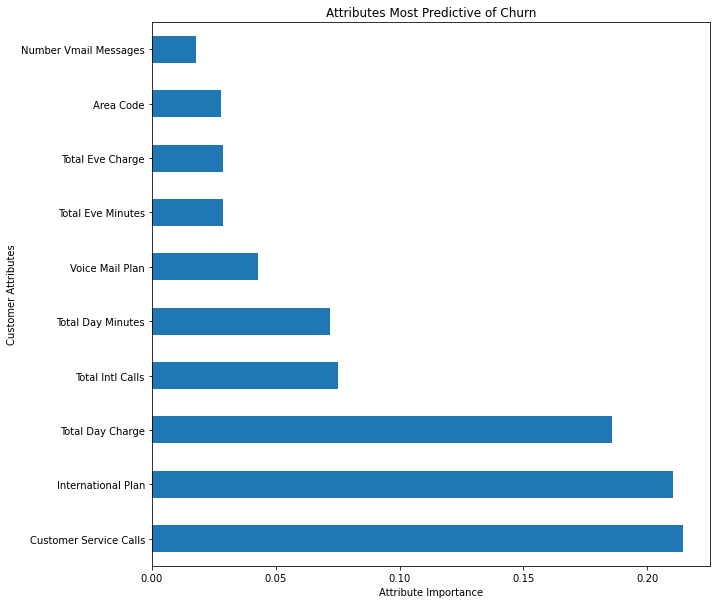

In [65]:
gbc_importances = get_feature_importance(gbc_pipeline, 'gbc', X_train, y_train)

### GridSearch--Gradiant Boosted Classifier

Now that we have a base model we started running grid searches to try and find the best hyper parameters for our gradient boosted classifier model.

In [66]:
# Print out original parameters of rf classifier in gbc_pipeline
print('Current Parameters:\n')
pprint(gbc_pipeline.named_steps['gbc'].get_params())

Current Parameters:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [67]:
# Define parameter grid to search over
gbc_params = {
            'gbc__n_estimators': [10, 20, 30],
            'gbc__min_samples_leaf': [1, 2, 4, 6],
            'gbc__min_samples_split': [2, 3, 4, 5, 10],
            'gbc__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'gbc__learning_rate': [0.05, 0.1, 0.2, 0.3]
             }

# Instantiate grid search object using parameters defined above.
# gbc_gs = GridSearchCV(gbc_pipeline, param_grid=gbc_params, n_jobs=-4, verbose=3, cv=10)

# Fit the grid search object on training data
# gbc_gs.fit(X_train, y_train)

# Find the best parameters based off of our grid search
# gbc_gs.best_params_

The first grid search found best parameters of:

- learning_rate: 0.3
- max_depth: 10
- min_samples_leaf: 4
- min_samples_split: 4
- n_estimators: 30

## GBC First Tune

Using the best parameters identified by our grid search, we re-ran the gradient boosted classifer on the training data. Results were slightly improved as the f1 score jumped by 4 percentage points, indicating that the model is working slightly better for our intended purposes.

In [68]:
gbc_tuned_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('gbct', GradientBoostingClassifier(learning_rate=0.3, 
                                                                           max_depth=10,
                                                                           min_samples_leaf=4,
                                                                           min_samples_split=4,
                                                                           n_estimators=30,
                                                                           random_state=42))]
                                )

In [69]:
gbc_tuned_pipeline.fit(X_train, y_train)
cross_val(gbc_tuned_pipeline, X_train, y_train)

Mean f1 score:  {0.8286899105115241} .
Median f1 score:  {0.845603813559322} .
Standard Deviation in f1 score:  {0.03953279405880199} .


In [70]:
gbc_tuned_y_hat = gbc_tuned_pipeline.predict(X_train)
print(classification_report(y_train, gbc_tuned_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



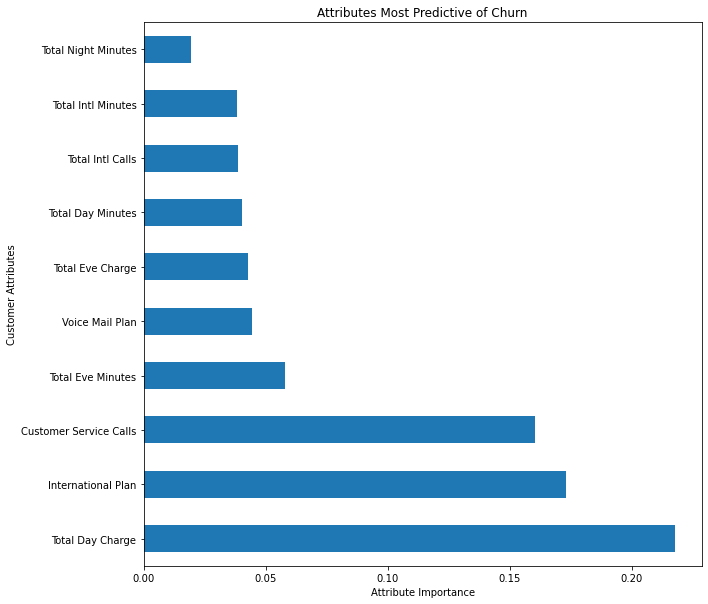

In [71]:
# Plot the 10 most important features
get_feature_importance(gbc_tuned_pipeline, 'gbct', X_train, y_train)

## Second Grid Search - GBC

After our first grid search, the gradient boosted classifier performed slightly better on the training data. We then attempted a second grid search based on a range of hyperparameters narrowed around the best parameters from the previous grid search.

The hyperparameters used in the second grid search were as follows:

In [72]:
gbc_params2 = {
            'gbc__n_estimators': [25, 50, 75, 100],
            'gbc__min_samples_leaf': [2, 3, 4, 5],
            'gbc__min_samples_split': [3, 4, 5, 6],
            'gbc__max_depth': [5, 10, 15, 20],
            'gbc__learning_rate': [0.2, 0.3, 0.4, 0.5]
             }

# Instantiate grid search object using parameters defined above.
# gbc_gs2 = GridSearchCV(gbc_pipeline, param_grid=gbc_params2, n_jobs=-4, verbose=3, cv=10)

# Fit the grid search object on training data
# gbc_gs2.fit(X_train, y_train)

# Find the best parameters based off of our grid search
# gbc_gs.best_params_

The second grid search found best parameters of:

- learning_rate: 0.3
- max_depth: 15
- min_samples_leaf: 5
- min_samples_split: 6
- n_estimators: 100

## GBC Second Tune

We then ran the gradient boosted classfier a third time using the parameters identified by our second grid search.

In [73]:
gbc_pipeline2 = ImPipeline(steps=[
                                  ('ct', CT),
                                  ('sm', sm),
                                  ('gbc', GradientBoostingClassifier(learning_rate=0.3,
                                                                     max_depth=15,
                                                                     min_samples_leaf=5,
                                                                     min_samples_split=6,
                                                                     n_estimators=100,
                                                                     random_state=42))
                                 ]
                          )

In [74]:
gbc_pipeline2.fit(X_train, y_train)
cross_val(gbc_pipeline2, X_train, y_train)

Mean f1 score:  {0.832789974476278} .
Median f1 score:  {0.8347394540942928} .
Standard Deviation in f1 score:  {0.03748409122238069} .


In [75]:
gbc2_y_hat = gbc_pipeline2.predict(X_train)
print(classification_report(y_train, gbc2_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



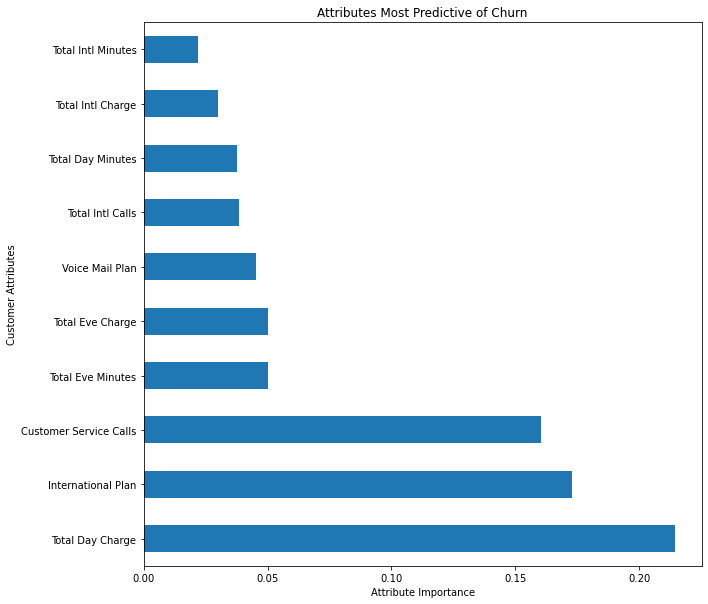

In [76]:
get_feature_importance(gbc_pipeline2, 'gbc', X_train, y_train)

## Third Grid Search - GBC

After our second grid search, the gradient boosted classifier performed even better than the first. given we were getting close to perfect parameters for the gradient boosting model we wanted to tweak them one last time to get our best model given our time constraints.

In [77]:
gbc_params3 = {
            'gbc__n_estimators': [100, 125, 150, 175, 200],
            'gbc__min_samples_leaf': [4, 5, 6, 7, 8],
            'gbc__min_samples_split': [5, 6, 7, 8, 9],
            'gbc__max_depth': [10, 15, 20],
            'gbc__learning_rate': [0.2, 0.3, 0.4, 0.5]
             }

# Instantiate grid search object using parameters defined above.
# gbc_gs3 = GridSearchCV(gbc_pipeline, param_grid=gbc_params3, n_jobs=-4, verbose=3, cv=10)

# Fit the grid search object on training data
# gbc_gs3.fit(X_train, y_train)

# Find the best parameters based off of our grid search
# gbc_gs.best_params_

The third grid search found best parameters of:

- learning_rate: 0.2
- max_depth: 15
- min_samples_leaf: 6
- min_samples_split: 5
- n_estimators: 200

## GBC Third Tune

This tuned model performed even better than the second model seeing that we went from .833 mean f1 score when cross validating to .837. Similarly to the random forest models we are starting to get diminishing returns from our improvements but our grid searches are requiring significantly more computing power and time with each iteration.

In [78]:
gbc_pipeline3 = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('gbc', GradientBoostingClassifier(learning_rate=0.2,
                                                                           max_depth=15,
                                                                           min_samples_leaf=6,
                                                                           min_samples_split=5,
                                                                           n_estimators=200,
                                                                           random_state=42))])

In [79]:
gbc_pipeline3.fit(X_train, y_train)
cross_val(gbc_pipeline3, X_train, y_train)

Mean f1 score:  {0.8369185895773917} .
Median f1 score:  {0.8452380952380952} .
Standard Deviation in f1 score:  {0.0421579280035602} .


In [80]:
gbc3_y_hat = gbc_pipeline3.predict(X_train)
print(classification_report(y_train, gbc3_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



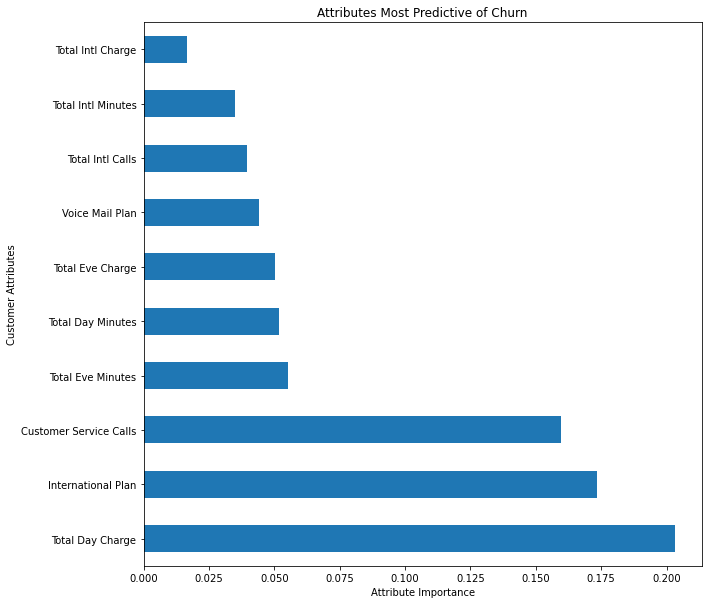

In [81]:
get_feature_importance(gbc_pipeline3, 'gbc', X_train, y_train)

## Final Model & Evaluation

After reviewing all of our models the best performing model was our third tuned gradient boosted classifier model. The Random Forest model was good but even our best tuned random forest was not as good as our base gradient boosted classifier model when comparing cross val scores. Our final model will be analysis using our best model we have chosen and we ran our test data on this model.

In [82]:
gbc_final_yhat = gbc_pipeline3.predict(X_test)
print(classification_report(y_test, gbc_final_yhat))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       940
        True       0.93      0.80      0.86       160

    accuracy                           0.96      1100
   macro avg       0.95      0.89      0.92      1100
weighted avg       0.96      0.96      0.96      1100



In [83]:
cross_val(gbc_pipeline3, X_test, y_test)

Mean f1 score:  {0.7992194911132621} .
Median f1 score:  {0.7867965367965368} .
Standard Deviation in f1 score:  {0.03879221419129113} .


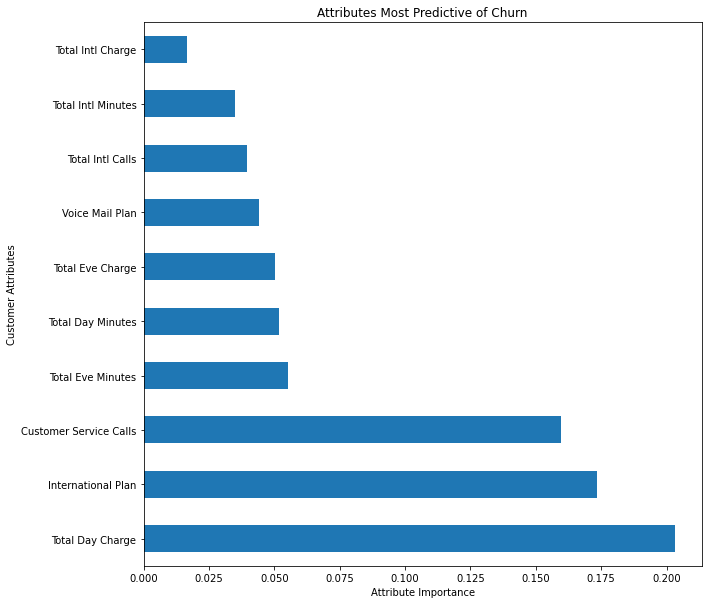

In [94]:
get_feature_importance(gbc_pipeline3, 'gbc', X_test, y_test)

In [84]:
# Final_model = grid_searched_pipeline.best_estimator_

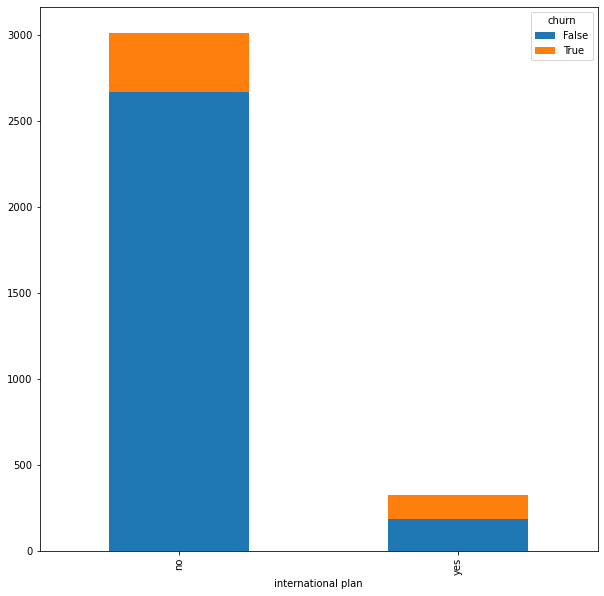

In [98]:
df.groupby([("international plan"), "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(10,10)); 

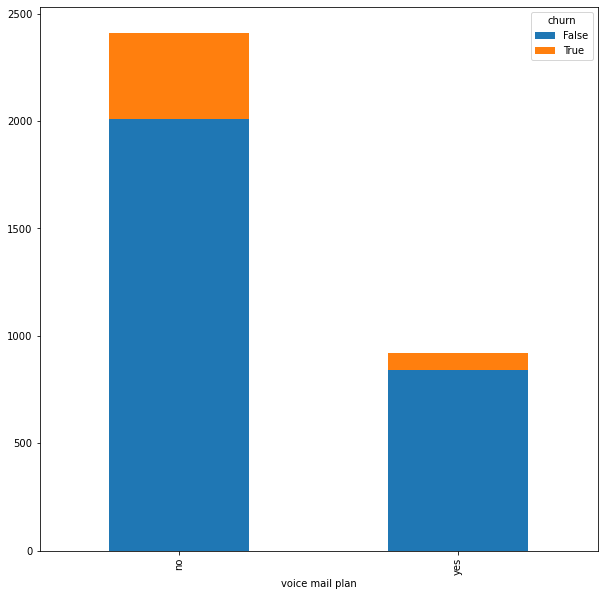

In [97]:
df.groupby([("voice mail plan"), "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(10,10)); 

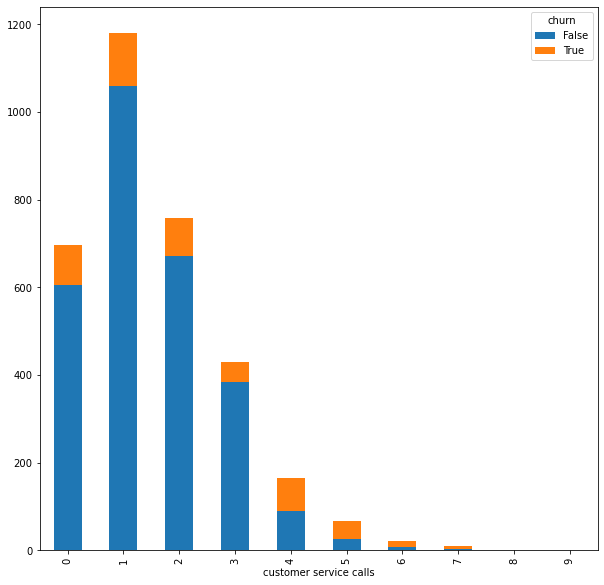

In [96]:
df.groupby([("customer service calls"), "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(10,10)); 

# Conclusion & Next Steps

# Recommendations